# Tier 1: CNN + BiLSTM Training

This notebook implements training for the **Tier 1** architecture:
- Multi-scale 1D CNN for local feature extraction
- Stacked BiLSTM for sequential modeling
- Dual output heads for Q8 and Q3 prediction

## Expected Performance
- Q3 Accuracy: ~82-85%
- Q8 Accuracy: ~70-74%

## 1. Setup & Configuration

In [1]:
import sys
sys.path.insert(0, '../..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import random
import os

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Import our modules
from src.config import Tier1Config, LEAKAGE_TRAIN_IDS
from src.data import ProteinDataset, create_dataloaders, collate_fn
from src.models.tier1_cnn_bilstm import CNNBiLSTM
from src.losses import get_multitask_loss
from src.augmentation import SequenceAugmenter, describe_augmentation_levels
from src.metrics import evaluate_model, plot_confusion_matrix, EvaluationReport
from src.training import Trainer, create_optimizer, create_scheduler, plot_training_history

## 2. Configuration

In [3]:
# Experiment configuration
config = Tier1Config(
    # Data
    max_seq_length=512,
    batch_size=32,
    
    # Model
    input_dim=40,  # 20 (one-hot) + 20 (BLOSUM62)
    use_blosum=True,
    cnn_filters=64,
    cnn_kernels=[3, 5, 7],
    lstm_hidden=256,
    lstm_layers=2,
    lstm_dropout=0.3,
    fc_hidden=256,
    fc_dropout=0.2,
    
    # Training
    learning_rate=1e-4,
    weight_decay=0.01,
    max_epochs=50,
    patience=10,
    gradient_clip=1.0,
    
    # Loss
    focal_gamma=2.0,
    q8_loss_weight=1.0,
    q3_loss_weight=0.5,
    
    # Augmentation
    augmentation_level=2,  # Light masking
    
    # Checkpointing
    checkpoint_dir='../../checkpoints/tier1_cnn_bilstm',
)

print("Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Batch size: {config.batch_size}")
print(f"  Max sequence length: {config.max_seq_length}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Augmentation level: {config.augmentation_level}")

Configuration:
  Model: tier1_cnn_bilstm
  Batch size: 32
  Max sequence length: 512
  Learning rate: 0.0001
  Augmentation level: 2


## 3. Data Loading

In [4]:
# Preview augmentation levels
describe_augmentation_levels()

AUGMENTATION LEVELS

Level 1: No augmentation (baseline)
  - Mask prob: 0.0
  - Substitute prob: 0.0
  - Crop prob: 0.0
  - Noise std: 0.0
  - Reverse prob: 0.0

Level 2: Light masking (5%)
  - Mask prob: 0.05
  - Substitute prob: 0.0
  - Crop prob: 0.0
  - Noise std: 0.0
  - Reverse prob: 0.0

Level 3: Moderate: masking (10%) + substitution (3%) + noise
  - Mask prob: 0.1
  - Substitute prob: 0.03
  - Crop prob: 0.0
  - Noise std: 0.01
  - Reverse prob: 0.0

Level 4: Aggressive: masking (15%) + substitution (5%) + cropping (20%)
  - Mask prob: 0.15
  - Substitute prob: 0.05
  - Crop prob: 0.2
  - Noise std: 0.02
  - Reverse prob: 0.0

Level 5: Experimental: heavy masking (20%) + all augmentations + reversal (10%)
  - Mask prob: 0.2
  - Substitute prob: 0.08
  - Crop prob: 0.3
  - Noise std: 0.03
  - Reverse prob: 0.1


In [5]:
# Create augmenter
augmenter = SequenceAugmenter(level=config.augmentation_level, seed=SEED)
print(f"\nUsing augmentation: {augmenter}")


Using augmentation: SequenceAugmenter(level=2, config=AugmentationConfig(mask_prob=0.05, substitute_prob=0.0, noise_std=0.0, crop_prob=0.0, min_crop_ratio=0.8, reverse_prob=0.0))


In [6]:
# Create data loaders
train_loader, val_loader = create_dataloaders(
    train_csv='../../data/train.csv',
    val_split=0.1,
    batch_size=config.batch_size,
    max_length=config.max_seq_length,
    use_blosum=config.use_blosum,
    use_positional=False,
    augmentation=augmenter,
    num_workers=4,
    seed=SEED,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 205
Val batches: 23


In [7]:
# Inspect a batch
sample_batch = next(iter(train_loader))
print(f"\nBatch contents:")
print(f"  Features shape: {sample_batch['features'].shape}")
print(f"  SST8 shape: {sample_batch['sst8'].shape}")
print(f"  SST3 shape: {sample_batch['sst3'].shape}")
print(f"  Lengths: {sample_batch['lengths'][:5]}")


Batch contents:
  Features shape: torch.Size([32, 512, 40])
  SST8 shape: torch.Size([32, 512])
  SST3 shape: torch.Size([32, 512])
  Lengths: tensor([512, 512, 512, 497, 393])


## 4. Model Initialization

In [8]:
# Create model
model = CNNBiLSTM(
    input_dim=config.input_dim,
    cnn_filters=config.cnn_filters,
    cnn_kernels=config.cnn_kernels,
    lstm_hidden=config.lstm_hidden,
    lstm_layers=config.lstm_layers,
    lstm_dropout=config.lstm_dropout,
    fc_hidden=config.fc_hidden,
    fc_dropout=config.fc_dropout,
)

print(model)
print(f"\nTotal parameters: {model.count_parameters():,}")

CNNBiLSTM(
  CNN: 192 channels
  BiLSTM: 512 hidden
  Parameters: 2,803,019
)

Total parameters: 2,803,019


In [9]:
# Test forward pass
model = model.to(DEVICE)
test_input = sample_batch['features'].to(DEVICE)
q8_out, q3_out = model(test_input)
print(f"Q8 output shape: {q8_out.shape}")
print(f"Q3 output shape: {q3_out.shape}")

Q8 output shape: torch.Size([32, 512, 8])
Q3 output shape: torch.Size([32, 512, 3])


## 5. Loss Function Setup

In [10]:
# Create multi-task loss with focal loss and class weights
loss_fn = get_multitask_loss(
    loss_type='focal',
    q8_weight=config.q8_loss_weight,
    q3_weight=config.q3_loss_weight,
    dynamic_weights=False,
    gamma=config.focal_gamma,
)

print(f"Loss function: {loss_fn}")

Loss function: MultiTaskLoss(
  (q8_loss_fn): FocalLoss()
  (q3_loss_fn): FocalLoss()
)


## 6. Training

In [11]:
# Create optimizer and scheduler
optimizer = create_optimizer(
    model,
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    optimizer_type='adamw',
)

scheduler = create_scheduler(
    optimizer,
    scheduler_type='cosine',
    num_epochs=config.max_epochs,
)

In [12]:
# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    checkpoint_dir=config.checkpoint_dir,
    gradient_clip=config.gradient_clip,
    log_every=100,
    use_amp=torch.cuda.is_available(),  # Use FP16 on GPU
    use_tracking=True,
    trackio_space_id='thethinkmachine/trackio',  # HuggingFace Space for logs
    experiment_name='tier1_cnn_bilstm',
    hub_model_id='thethinkmachine/ProteinSST-CNNBiLSTM',
    training_config=config,
)

In [13]:
# Train!
history = trainer.train(
    num_epochs=config.max_epochs,
    patience=config.patience,
    save_every=5,
)

📊 Logging to HuggingFace Space: thethinkmachine/trackio
* Trackio project initialized: tier1_cnn_bilstm
* Trackio metrics will be synced to Hugging Face Dataset: thethinkmachine/trackio-dataset
* Found existing space: https://huggingface.co/spaces/thethinkmachine/trackio
* View dashboard by going to: https://thethinkmachine-trackio.hf.space/


* Created new run: thethinkmachine-1765717893
✓ Experiment tracking enabled (Trackio)
Starting training for 50 epochs...
Device: cuda
Model parameters: 2,803,019


Epoch 1: 100%|██████████| 205/205 [00:09<00:00, 21.31it/s, loss=1.08, q8_loss=0.932, q3_loss=0.288] 


Epoch 1/50 (10.3s) | Train Loss: 1.0644 | Val Loss: 0.9140 | Q8 Acc: 0.4289 | Q3 Acc: 0.6403 | Q8 F1: 0.2649 | Q3 F1: 0.6336 | H-F1: 0.3736 | LR: 0.000099 *


Epoch 2: 100%|██████████| 205/205 [00:08<00:00, 22.79it/s, loss=1.09, q8_loss=0.96, q3_loss=0.262]  


Epoch 2/50 (9.6s) | Train Loss: 0.9635 | Val Loss: 0.8760 | Q8 Acc: 0.4529 | Q3 Acc: 0.6610 | Q8 F1: 0.2875 | Q3 F1: 0.6542 | H-F1: 0.3995 | LR: 0.000096 *


Epoch 3: 100%|██████████| 205/205 [00:08<00:00, 22.90it/s, loss=1.1, q8_loss=0.955, q3_loss=0.293]  


Epoch 3/50 (9.6s) | Train Loss: 0.9351 | Val Loss: 0.8526 | Q8 Acc: 0.4529 | Q3 Acc: 0.6591 | Q8 F1: 0.2922 | Q3 F1: 0.6565 | H-F1: 0.4044 | LR: 0.000092 *


Epoch 4: 100%|██████████| 205/205 [00:09<00:00, 22.60it/s, loss=0.859, q8_loss=0.741, q3_loss=0.236]


Epoch 4/50 (9.7s) | Train Loss: 0.9158 | Val Loss: 0.8393 | Q8 Acc: 0.4671 | Q3 Acc: 0.6658 | Q8 F1: 0.2991 | Q3 F1: 0.6632 | H-F1: 0.4122 | LR: 0.000086 *


Epoch 5: 100%|██████████| 205/205 [00:09<00:00, 22.50it/s, loss=0.892, q8_loss=0.769, q3_loss=0.247]


Epoch 5/50 (9.8s) | Train Loss: 0.9048 | Val Loss: 0.8292 | Q8 Acc: 0.4717 | Q3 Acc: 0.6744 | Q8 F1: 0.3045 | Q3 F1: 0.6713 | H-F1: 0.4189 | LR: 0.000078 *


Epoch 6: 100%|██████████| 205/205 [00:09<00:00, 22.75it/s, loss=0.854, q8_loss=0.735, q3_loss=0.237]


Epoch 6/50 (9.7s) | Train Loss: 0.8921 | Val Loss: 0.8293 | Q8 Acc: 0.4759 | Q3 Acc: 0.6867 | Q8 F1: 0.3092 | Q3 F1: 0.6792 | H-F1: 0.4250 | LR: 0.000069 *


Epoch 7: 100%|██████████| 205/205 [00:09<00:00, 22.54it/s, loss=0.971, q8_loss=0.839, q3_loss=0.263]


Epoch 7/50 (9.6s) | Train Loss: 0.8848 | Val Loss: 0.8187 | Q8 Acc: 0.4700 | Q3 Acc: 0.6838 | Q8 F1: 0.3068 | Q3 F1: 0.6791 | H-F1: 0.4227 | LR: 0.000060


Epoch 8: 100%|██████████| 205/205 [00:08<00:00, 22.93it/s, loss=0.841, q8_loss=0.732, q3_loss=0.219]


Epoch 8/50 (9.6s) | Train Loss: 0.8792 | Val Loss: 0.8129 | Q8 Acc: 0.4812 | Q3 Acc: 0.6900 | Q8 F1: 0.3132 | Q3 F1: 0.6848 | H-F1: 0.4298 | LR: 0.000051 *


Epoch 9: 100%|██████████| 205/205 [00:08<00:00, 22.79it/s, loss=0.826, q8_loss=0.701, q3_loss=0.249]


Epoch 9/50 (9.5s) | Train Loss: 0.8732 | Val Loss: 0.8128 | Q8 Acc: 0.4708 | Q3 Acc: 0.6715 | Q8 F1: 0.3053 | Q3 F1: 0.6698 | H-F1: 0.4194 | LR: 0.000041


Epoch 10: 100%|██████████| 205/205 [00:08<00:00, 22.87it/s, loss=0.855, q8_loss=0.739, q3_loss=0.232]


Epoch 10/50 (9.6s) | Train Loss: 0.8681 | Val Loss: 0.8059 | Q8 Acc: 0.4945 | Q3 Acc: 0.6860 | Q8 F1: 0.3179 | Q3 F1: 0.6824 | H-F1: 0.4338 | LR: 0.000032 *


Epoch 11: 100%|██████████| 205/205 [00:09<00:00, 22.36it/s, loss=0.767, q8_loss=0.665, q3_loss=0.205]


Epoch 11/50 (9.8s) | Train Loss: 0.8644 | Val Loss: 0.8053 | Q8 Acc: 0.4962 | Q3 Acc: 0.6907 | Q8 F1: 0.3219 | Q3 F1: 0.6868 | H-F1: 0.4383 | LR: 0.000023 *


Epoch 12: 100%|██████████| 205/205 [00:09<00:00, 22.73it/s, loss=0.879, q8_loss=0.753, q3_loss=0.252]


Epoch 12/50 (9.6s) | Train Loss: 0.8618 | Val Loss: 0.8041 | Q8 Acc: 0.4741 | Q3 Acc: 0.6929 | Q8 F1: 0.3133 | Q3 F1: 0.6889 | H-F1: 0.4308 | LR: 0.000015


Epoch 13: 100%|██████████| 205/205 [00:09<00:00, 22.73it/s, loss=0.814, q8_loss=0.709, q3_loss=0.209]


Epoch 13/50 (9.6s) | Train Loss: 0.8576 | Val Loss: 0.8052 | Q8 Acc: 0.4924 | Q3 Acc: 0.6930 | Q8 F1: 0.3186 | Q3 F1: 0.6874 | H-F1: 0.4354 | LR: 0.000009


Epoch 14: 100%|██████████| 205/205 [00:08<00:00, 22.87it/s, loss=0.788, q8_loss=0.679, q3_loss=0.219]


Epoch 14/50 (9.5s) | Train Loss: 0.8561 | Val Loss: 0.8027 | Q8 Acc: 0.4893 | Q3 Acc: 0.6931 | Q8 F1: 0.3173 | Q3 F1: 0.6881 | H-F1: 0.4344 | LR: 0.000005


Epoch 15: 100%|██████████| 205/205 [00:09<00:00, 22.64it/s, loss=0.726, q8_loss=0.619, q3_loss=0.213]


Epoch 15/50 (9.6s) | Train Loss: 0.8547 | Val Loss: 0.8020 | Q8 Acc: 0.4857 | Q3 Acc: 0.6930 | Q8 F1: 0.3165 | Q3 F1: 0.6885 | H-F1: 0.4337 | LR: 0.000002


Epoch 16: 100%|██████████| 205/205 [00:09<00:00, 22.75it/s, loss=0.793, q8_loss=0.693, q3_loss=0.2]  


Epoch 16/50 (9.6s) | Train Loss: 0.8544 | Val Loss: 0.8003 | Q8 Acc: 0.4874 | Q3 Acc: 0.6914 | Q8 F1: 0.3174 | Q3 F1: 0.6878 | H-F1: 0.4343 | LR: 0.000100


Epoch 17: 100%|██████████| 205/205 [00:09<00:00, 22.17it/s, loss=0.941, q8_loss=0.813, q3_loss=0.256]


Epoch 17/50 (9.8s) | Train Loss: 0.8642 | Val Loss: 0.8208 | Q8 Acc: 0.4600 | Q3 Acc: 0.6560 | Q8 F1: 0.3014 | Q3 F1: 0.6560 | H-F1: 0.4130 | LR: 0.000100


Epoch 18: 100%|██████████| 205/205 [00:09<00:00, 22.34it/s, loss=0.839, q8_loss=0.698, q3_loss=0.281]


Epoch 18/50 (9.9s) | Train Loss: 0.8588 | Val Loss: 0.7978 | Q8 Acc: 0.5045 | Q3 Acc: 0.6885 | Q8 F1: 0.3234 | Q3 F1: 0.6846 | H-F1: 0.4393 | LR: 0.000099 *


Epoch 19: 100%|██████████| 205/205 [00:09<00:00, 22.38it/s, loss=0.843, q8_loss=0.734, q3_loss=0.218]


Epoch 19/50 (9.7s) | Train Loss: 0.8513 | Val Loss: 0.7999 | Q8 Acc: 0.4777 | Q3 Acc: 0.6971 | Q8 F1: 0.3187 | Q3 F1: 0.6920 | H-F1: 0.4364 | LR: 0.000098


Epoch 20: 100%|██████████| 205/205 [00:09<00:00, 21.76it/s, loss=0.92, q8_loss=0.801, q3_loss=0.237] 


Epoch 20/50 (10.1s) | Train Loss: 0.8480 | Val Loss: 0.7948 | Q8 Acc: 0.4977 | Q3 Acc: 0.6974 | Q8 F1: 0.3260 | Q3 F1: 0.6925 | H-F1: 0.4433 | LR: 0.000096 *


Epoch 21: 100%|██████████| 205/205 [00:09<00:00, 22.02it/s, loss=1.09, q8_loss=0.941, q3_loss=0.29]  


Epoch 21/50 (9.9s) | Train Loss: 0.8424 | Val Loss: 0.8070 | Q8 Acc: 0.4692 | Q3 Acc: 0.6721 | Q8 F1: 0.3098 | Q3 F1: 0.6713 | H-F1: 0.4240 | LR: 0.000094


Epoch 22: 100%|██████████| 205/205 [00:09<00:00, 22.35it/s, loss=0.657, q8_loss=0.559, q3_loss=0.196]


Epoch 22/50 (9.7s) | Train Loss: 0.8390 | Val Loss: 0.7876 | Q8 Acc: 0.4856 | Q3 Acc: 0.6948 | Q8 F1: 0.3187 | Q3 F1: 0.6917 | H-F1: 0.4364 | LR: 0.000092


Epoch 23: 100%|██████████| 205/205 [00:09<00:00, 21.96it/s, loss=0.892, q8_loss=0.761, q3_loss=0.264]


Epoch 23/50 (9.9s) | Train Loss: 0.8302 | Val Loss: 0.7863 | Q8 Acc: 0.4968 | Q3 Acc: 0.6922 | Q8 F1: 0.3227 | Q3 F1: 0.6897 | H-F1: 0.4397 | LR: 0.000089


Epoch 24: 100%|██████████| 205/205 [00:09<00:00, 22.44it/s, loss=0.798, q8_loss=0.693, q3_loss=0.211]


Epoch 24/50 (9.7s) | Train Loss: 0.8273 | Val Loss: 0.8002 | Q8 Acc: 0.4960 | Q3 Acc: 0.6972 | Q8 F1: 0.3248 | Q3 F1: 0.6903 | H-F1: 0.4417 | LR: 0.000086


Epoch 25: 100%|██████████| 205/205 [00:09<00:00, 21.83it/s, loss=0.846, q8_loss=0.729, q3_loss=0.235]


Epoch 25/50 (10.0s) | Train Loss: 0.8195 | Val Loss: 0.7863 | Q8 Acc: 0.4994 | Q3 Acc: 0.6894 | Q8 F1: 0.3247 | Q3 F1: 0.6873 | H-F1: 0.4411 | LR: 0.000082


Epoch 26: 100%|██████████| 205/205 [00:09<00:00, 22.47it/s, loss=0.785, q8_loss=0.682, q3_loss=0.207]


Epoch 26/50 (9.8s) | Train Loss: 0.8160 | Val Loss: 0.7864 | Q8 Acc: 0.5098 | Q3 Acc: 0.6953 | Q8 F1: 0.3297 | Q3 F1: 0.6909 | H-F1: 0.4464 | LR: 0.000078 *


Epoch 27: 100%|██████████| 205/205 [00:09<00:00, 22.45it/s, loss=0.88, q8_loss=0.756, q3_loss=0.246] 


Epoch 27/50 (9.7s) | Train Loss: 0.8120 | Val Loss: 0.7832 | Q8 Acc: 0.5031 | Q3 Acc: 0.6943 | Q8 F1: 0.3258 | Q3 F1: 0.6909 | H-F1: 0.4428 | LR: 0.000074


Epoch 28: 100%|██████████| 205/205 [00:09<00:00, 22.19it/s, loss=0.709, q8_loss=0.606, q3_loss=0.206]


Epoch 28/50 (9.8s) | Train Loss: 0.8066 | Val Loss: 0.7833 | Q8 Acc: 0.4986 | Q3 Acc: 0.6984 | Q8 F1: 0.3266 | Q3 F1: 0.6955 | H-F1: 0.4445 | LR: 0.000069


Epoch 29: 100%|██████████| 205/205 [00:09<00:00, 22.55it/s, loss=0.759, q8_loss=0.656, q3_loss=0.207]


Epoch 29/50 (9.7s) | Train Loss: 0.8021 | Val Loss: 0.7938 | Q8 Acc: 0.4964 | Q3 Acc: 0.7014 | Q8 F1: 0.3268 | Q3 F1: 0.6956 | H-F1: 0.4447 | LR: 0.000065


Epoch 30: 100%|██████████| 205/205 [00:09<00:00, 21.78it/s, loss=0.729, q8_loss=0.633, q3_loss=0.191]


Epoch 30/50 (10.0s) | Train Loss: 0.7982 | Val Loss: 0.7887 | Q8 Acc: 0.4898 | Q3 Acc: 0.7067 | Q8 F1: 0.3267 | Q3 F1: 0.7009 | H-F1: 0.4456 | LR: 0.000060


Epoch 31: 100%|██████████| 205/205 [00:09<00:00, 22.20it/s, loss=0.826, q8_loss=0.728, q3_loss=0.195]


Epoch 31/50 (9.9s) | Train Loss: 0.7947 | Val Loss: 0.7814 | Q8 Acc: 0.4959 | Q3 Acc: 0.7070 | Q8 F1: 0.3294 | Q3 F1: 0.7033 | H-F1: 0.4487 | LR: 0.000055 *


Epoch 32: 100%|██████████| 205/205 [00:09<00:00, 22.29it/s, loss=0.893, q8_loss=0.779, q3_loss=0.228]


Epoch 32/50 (9.8s) | Train Loss: 0.7922 | Val Loss: 0.7803 | Q8 Acc: 0.4941 | Q3 Acc: 0.7018 | Q8 F1: 0.3259 | Q3 F1: 0.6988 | H-F1: 0.4445 | LR: 0.000051


Epoch 33: 100%|██████████| 205/205 [00:09<00:00, 22.41it/s, loss=0.671, q8_loss=0.565, q3_loss=0.211]


Epoch 33/50 (9.7s) | Train Loss: 0.7881 | Val Loss: 0.7924 | Q8 Acc: 0.4936 | Q3 Acc: 0.6923 | Q8 F1: 0.3263 | Q3 F1: 0.6903 | H-F1: 0.4432 | LR: 0.000046


Epoch 34: 100%|██████████| 205/205 [00:09<00:00, 22.25it/s, loss=0.883, q8_loss=0.77, q3_loss=0.225] 


Epoch 34/50 (9.8s) | Train Loss: 0.7861 | Val Loss: 0.7829 | Q8 Acc: 0.4942 | Q3 Acc: 0.7004 | Q8 F1: 0.3269 | Q3 F1: 0.6977 | H-F1: 0.4452 | LR: 0.000041


Epoch 35: 100%|██████████| 205/205 [00:09<00:00, 22.36it/s, loss=0.874, q8_loss=0.753, q3_loss=0.243]


Epoch 35/50 (9.8s) | Train Loss: 0.7815 | Val Loss: 0.7891 | Q8 Acc: 0.4888 | Q3 Acc: 0.6931 | Q8 F1: 0.3245 | Q3 F1: 0.6911 | H-F1: 0.4417 | LR: 0.000036


Epoch 36: 100%|██████████| 205/205 [00:09<00:00, 22.10it/s, loss=0.802, q8_loss=0.698, q3_loss=0.209]


Epoch 36/50 (9.9s) | Train Loss: 0.7794 | Val Loss: 0.7848 | Q8 Acc: 0.4844 | Q3 Acc: 0.7041 | Q8 F1: 0.3236 | Q3 F1: 0.7003 | H-F1: 0.4426 | LR: 0.000032


Epoch 37: 100%|██████████| 205/205 [00:09<00:00, 22.62it/s, loss=0.692, q8_loss=0.587, q3_loss=0.21] 


Epoch 37/50 (9.7s) | Train Loss: 0.7766 | Val Loss: 0.7900 | Q8 Acc: 0.5014 | Q3 Acc: 0.7017 | Q8 F1: 0.3287 | Q3 F1: 0.6971 | H-F1: 0.4467 | LR: 0.000027


Epoch 38: 100%|██████████| 205/205 [00:09<00:00, 21.75it/s, loss=0.698, q8_loss=0.604, q3_loss=0.188]


Epoch 38/50 (10.1s) | Train Loss: 0.7747 | Val Loss: 0.7830 | Q8 Acc: 0.4975 | Q3 Acc: 0.7020 | Q8 F1: 0.3268 | Q3 F1: 0.6986 | H-F1: 0.4452 | LR: 0.000023


Epoch 39: 100%|██████████| 205/205 [00:09<00:00, 21.96it/s, loss=0.749, q8_loss=0.652, q3_loss=0.194]


Epoch 39/50 (9.9s) | Train Loss: 0.7734 | Val Loss: 0.7844 | Q8 Acc: 0.4869 | Q3 Acc: 0.7027 | Q8 F1: 0.3243 | Q3 F1: 0.6993 | H-F1: 0.4432 | LR: 0.000019


Epoch 40: 100%|██████████| 205/205 [00:09<00:00, 21.75it/s, loss=0.729, q8_loss=0.626, q3_loss=0.205]


Epoch 40/50 (10.0s) | Train Loss: 0.7708 | Val Loss: 0.7876 | Q8 Acc: 0.4979 | Q3 Acc: 0.7020 | Q8 F1: 0.3291 | Q3 F1: 0.6987 | H-F1: 0.4475 | LR: 0.000015


Epoch 41: 100%|██████████| 205/205 [00:09<00:00, 21.89it/s, loss=0.749, q8_loss=0.65, q3_loss=0.199] 


Epoch 41/50 (10.0s) | Train Loss: 0.7684 | Val Loss: 0.7862 | Q8 Acc: 0.5019 | Q3 Acc: 0.7019 | Q8 F1: 0.3302 | Q3 F1: 0.6988 | H-F1: 0.4485 | LR: 0.000012

Early stopping triggered at epoch 41
* Run finished. Uploading logs to Trackio (please wait...)
✓ Experiment tracking finished


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✓ Model pushed to: https://huggingface.co/thethinkmachine/ProteinSST-CNNBiLSTM

Training complete!
Best Harmonic F1: 0.4487
Best Q8 F1: 0.3294
Best Q8 Accuracy: 0.4959
Best Val Loss: 0.7814


## 7. Training Visualization

/tmp/ipykernel_427743/661974001.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


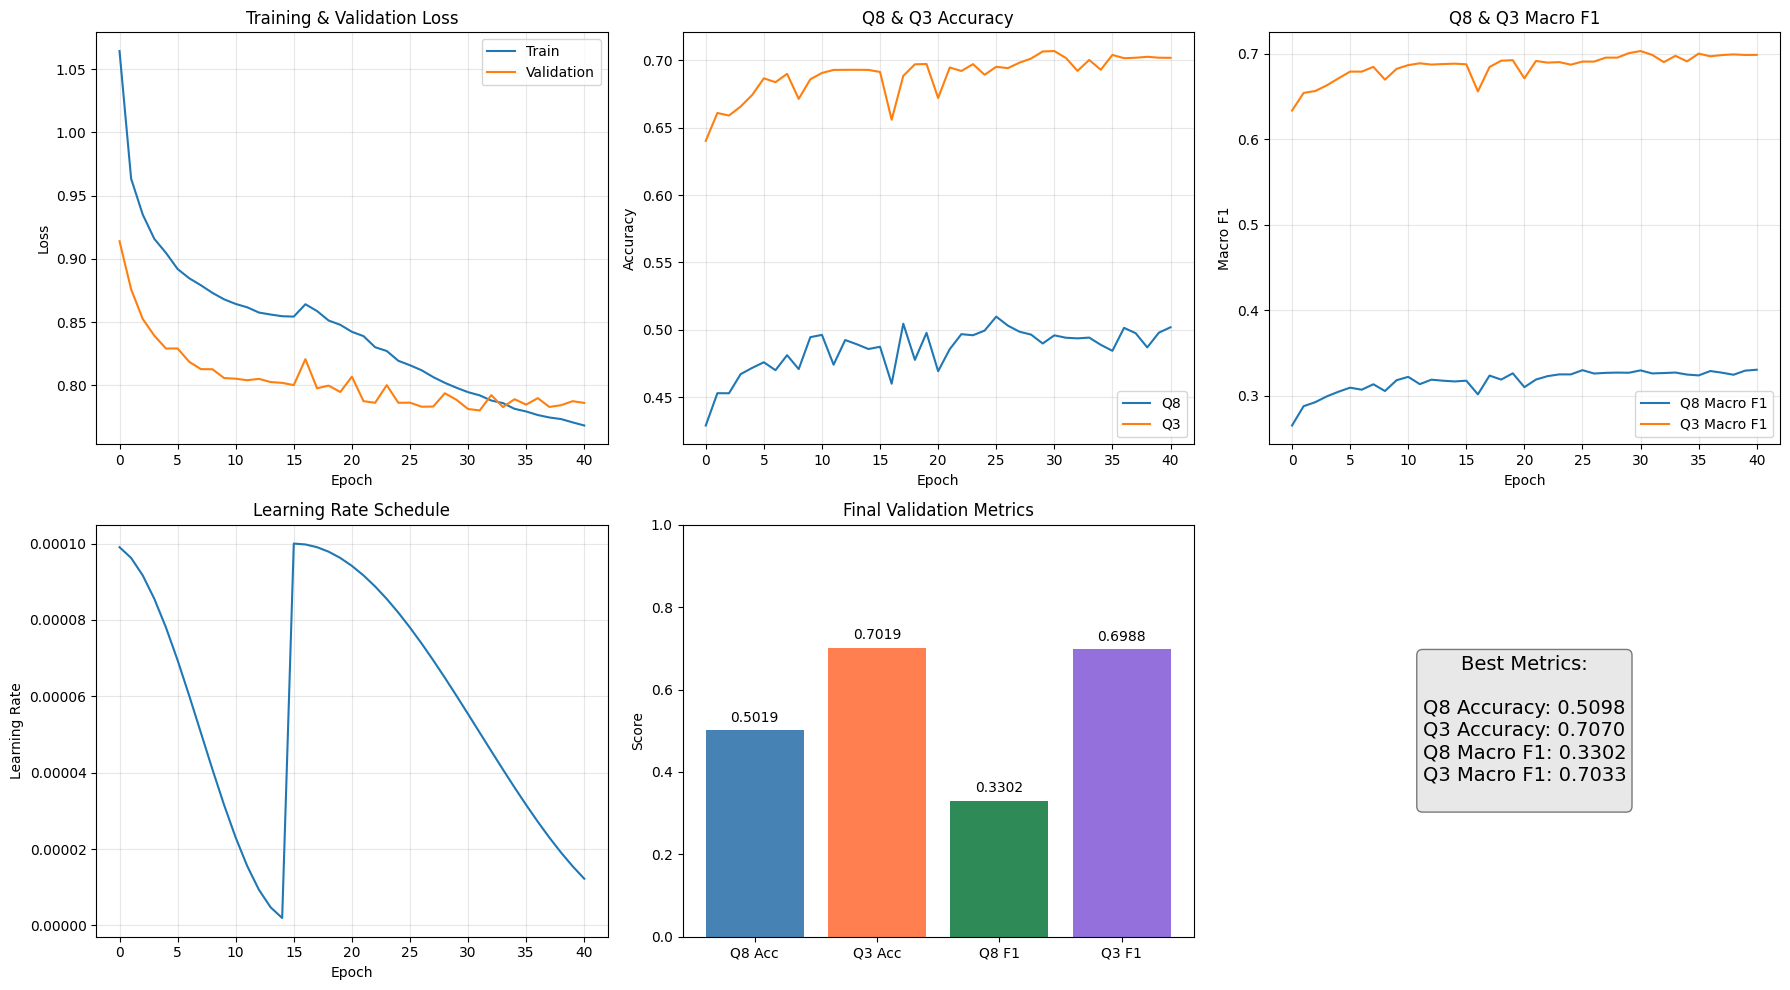

In [14]:
# Plot training history
fig = plot_training_history(history, save_path=f'{config.checkpoint_dir}/training_history.png')
fig.show()

## 8. Evaluation

In [15]:
# Load best model
checkpoint = torch.load(f'{config.checkpoint_dir}/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

Loaded best model from epoch 31


In [16]:
# Full evaluation
report = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=DEVICE,
    compute_sov=True,
)

report.print_report()

EVALUATION REPORT

============================== Q8 (8-state) ==============================
Accuracy: 0.4959 (49.59%)
Macro F1: 0.3294
SOV Score: 54.88

Per-class metrics:
Class           Precision    Recall       F1           Support   
------------------------------------------------------------
G (3₁₀-helix)   0.1141       0.4788       0.1843       6420
H (α-helix)     0.8114       0.6548       0.7247       52250
I (π-helix)     0.0000       0.0000       0.0000       23
E (β-strand)    0.6281       0.6622       0.6447       37526
B (β-bridge)    0.0415       0.3018       0.0730       1809
T (Turn)        0.3359       0.4921       0.3992       18325
S (Bend)        0.2855       0.1886       0.2271       13162
C (Coil)        0.7909       0.2522       0.3824       40857

============================== Q3 (3-state) ==============================
Accuracy: 0.7070 (70.70%)
Macro F1: 0.7033
SOV Score: 75.50

Per-class metrics:
Class           Precision    Recall       F1           Suppo

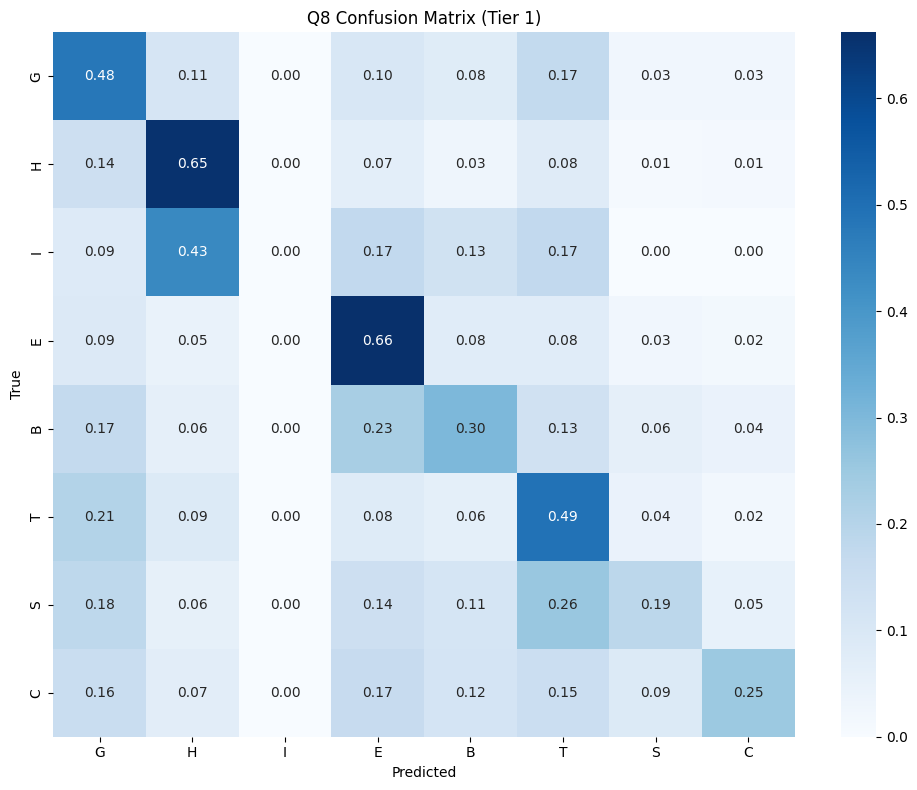

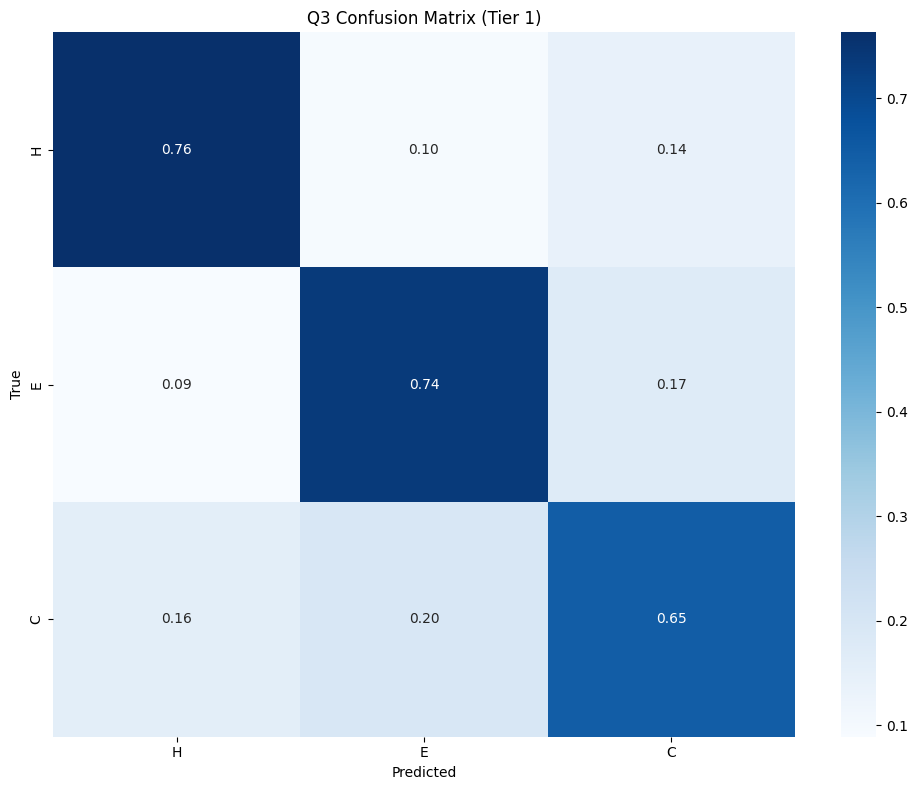

In [17]:
# Plot confusion matrices
from src.config import SST8_CLASSES, SST3_CLASSES

fig_q8 = plot_confusion_matrix(
    report.q8_confusion_matrix,
    SST8_CLASSES,
    title='Q8 Confusion Matrix (Tier 1)',
    save_path=f'{config.checkpoint_dir}/q8_confusion_matrix.png',
)

fig_q3 = plot_confusion_matrix(
    report.q3_confusion_matrix,
    SST3_CLASSES,
    title='Q3 Confusion Matrix (Tier 1)',
    save_path=f'{config.checkpoint_dir}/q3_confusion_matrix.png',
)

## 9. Summary

In [18]:
print("=" * 60)
print("TIER 1 TRAINING COMPLETE")
print("=" * 60)
print(f"\nBest Results:")
print(f"  Q8 Accuracy: {report.q8_accuracy:.4f} ({report.q8_accuracy*100:.2f}%)")
print(f"  Q3 Accuracy: {report.q3_accuracy:.4f} ({report.q3_accuracy*100:.2f}%)")
print(f"  Q8 Macro F1: {report.q8_macro_f1:.4f}")
print(f"  Q3 Macro F1: {report.q3_macro_f1:.4f}")
if report.q8_sov:
    print(f"  Q8 SOV: {report.q8_sov:.2f}")
    print(f"  Q3 SOV: {report.q3_sov:.2f}")

print(f"\nCheckpoints saved to: {config.checkpoint_dir}")

TIER 1 TRAINING COMPLETE

Best Results:
  Q8 Accuracy: 0.4959 (49.59%)
  Q3 Accuracy: 0.7070 (70.70%)
  Q8 Macro F1: 0.3294
  Q3 Macro F1: 0.7033
  Q8 SOV: 54.88
  Q3 SOV: 75.50

Checkpoints saved to: ../../checkpoints/tier1_cnn_bilstm
